<a href="https://colab.research.google.com/github/ziyacanyldz/FlowersRecognition-AlexNet-Vgg16-ResNet/blob/main/Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get update #Depolama alanlarını güncelleme.

Reading package lists... Done


In [ ]:
%pwd #bulunduğumuz adresi gösterir.

'/content'

In [ ]:
import os
import numpy as np 
import pandas as pd 
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Activation, Dense
from keras.preprocessing import image

import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Tensorflow Cuda uyarılarından kurtulmak için.

In [ ]:
!unzip "/content/drive/MyDrive/flowerdataset.zip"

In [ ]:
print("Tensorflow version " + tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found - On for CPU time!')
else:
    print('Found GPU at {}'.format(device_name))

Tensorflow version 2.8.0
Found GPU at /device:GPU:0


# GÖRSELLEŞTİRME

In [ ]:
IMAGE_SIZE = 150,150
CLASSES = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
src = '/content/flowerdataset/train'
src2 = '/content/flowerdataset/test'

train = []
test = []

def duzenle(source,data):
  for i in CLASSES:
      path = os.path.join(source,i)
      idx = CLASSES.index(i)
      for img in os.listdir(path):
          if img.endswith('.jpg'):
              img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
              img_array = cv2.resize(img_array, IMAGE_SIZE)
              data.append([img_array, idx])
              random.shuffle(data)

duzenle(src,train)
duzenle(src2,test)

X_train=[] 
y_train=[] 

X_test=[]
y_test=[]

for i,j in train:
    X_train.append(i)
    y_train.append(j)
for i,j in test:
    X_test.append(i)
    y_test.append(j)

#burası görselleştirilme için kullanıldı, fitlerken liste kullanamayacağımız için data büyütme kısmında verimiz data generator olarak ayrılacaktır.

In [ ]:
print("train : ",len(train))
print("test : ",len(test))
toplam = len(train)+len(test)
print("toplam : ",toplam)

train :  3456
test :  860
toplam :  4316


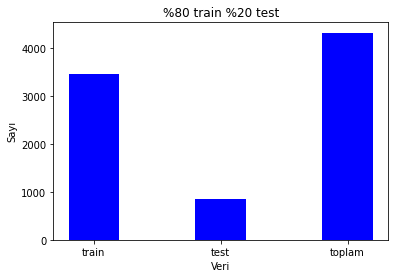

In [ ]:
plt.bar(["train","test","toplam"], [len(train),len(test),toplam], color ='blue',
        width = 0.4)
 
plt.xlabel("Veri")
plt.ylabel("Sayı")
plt.title("%80 train %20 test")
plt.show()

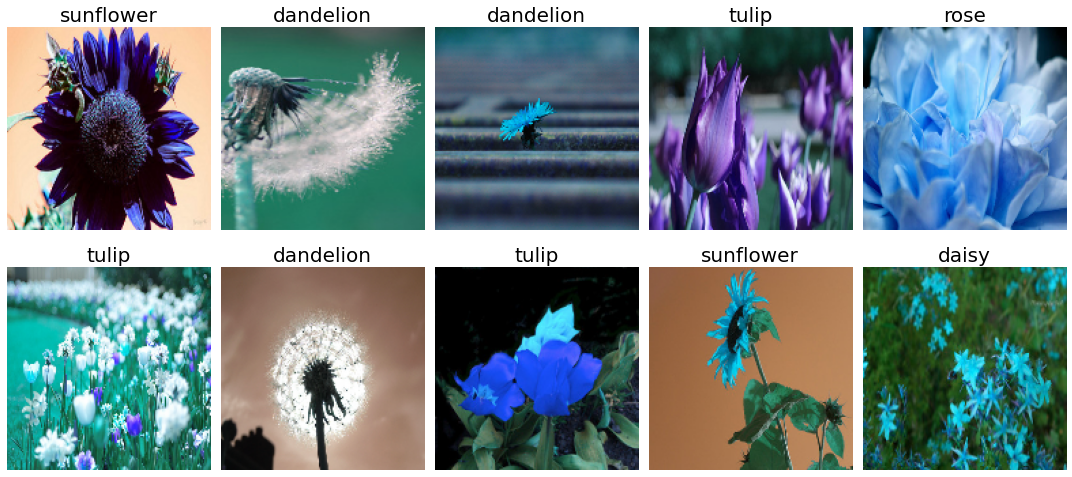

In [ ]:
ROWS = 2
COLS = 5

fig,ax = plt.subplots(ROWS, COLS)
fig.set_size_inches(15,7)

for i in range(ROWS):
    for j in range(COLS):
        l = np.random.randint(0, len(y_train))
        ax[i,j].imshow(X_train[l])
        ax[i,j].set_title(CLASSES[y_train[l]], fontsize = 20)
        ax[i,j].axis('off')        
plt.tight_layout()

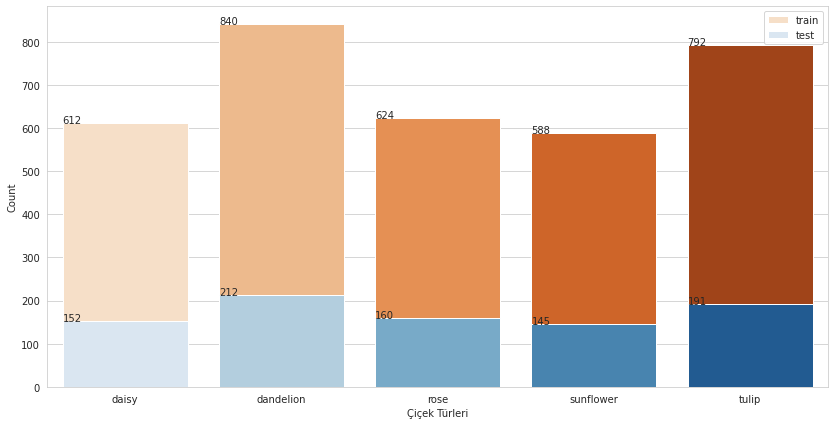

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize = (14,7))
fig = sns.countplot(x = y_train, palette = "Oranges")
fig2 = sns.countplot(x = y_test, palette = "Blues")
fig.set(xticks = range(len(CLASSES)), xticklabels = [i for i in CLASSES])
plt.legend(["train","test"])

plt.xlabel('Çiçek Türleri')
plt.ylabel('Count')

for p in fig.patches:
        fig.annotate('{:.0f}'.format(p.get_height()), (p.get_x(), p.get_height()))
plt.show()

# ALEXNET İLE MODEL OLUŞTURMA

In [ ]:
#class üzerinde AlexNet fonksiyonu oluşturduk.
#fonksiyon 2 parametre içerir input shape'i ve class sayısı
#Conv2D filtreleri olarak 11x11, 3x3 ve 5x5 kernel sizeda kullanır.
#softmax activationa kadar bütün conv ve dense katmanlarda relu

class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, fill_mode='nearest',
                                   rotation_range=10 , zoom_range = 0.1)

# test verisinin orijinal kalmasını istiyoruz.
test_datagen = ImageDataGenerator(rescale=1./255)

#Data büyütme ile daha iyi başarı oranı yakalamak istiyoruz. Bu sayede daha fazla verimiz olacak ve overfittingi önlemiş olucaz.

#rescale: normalizasyon işlemi
#horizantal_flip : resmi ters çevirme (yatay)
#width_shift : verilen değerde resmi rastgele oynatma
#fill mode: nearest seçildi fotoğraf değiştiğinde boş kalan pikselleri en yakın piksellerle doldurma

In [ ]:
#generator oluşturma
train_generator = train_datagen.flow_from_directory('/content/flowerdataset/train', target_size=(224, 224), batch_size=64, class_mode='binary')

test_generator = test_datagen.flow_from_directory('/content/flowerdataset/test', target_size=(224, 224), batch_size=64, class_mode='binary', shuffle= False)

Found 3456 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [ ]:
model = AlexNet((224, 224, 3), len(CLASSES))

In [ ]:
model.summary()

Model: "alex_net_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 12, 12, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 12, 12, 384)       885120    
                                                                 
 conv2d_28 (Conv2D)          (None, 12, 12, 384)       1

In [ ]:
history = model.fit(train_generator, epochs=60, steps_per_epoch=len(train_generator), validation_data= test_generator, validation_steps=len(test_generator), batch_size= 128)

Epoch 1/60
54/54 [==============================] - 55s 981ms/step - loss: 1.4913 - accuracy: 0.3660 - val_loss: 1.2320 - val_accuracy: 0.5012
Epoch 2/60
54/54 [==============================] - 52s 955ms/step - loss: 1.1722 - accuracy: 0.4962 - val_loss: 1.2519 - val_accuracy: 0.4570
Epoch 3/60
54/54 [==============================] - 51s 949ms/step - loss: 1.0847 - accuracy: 0.5498 - val_loss: 1.2168 - val_accuracy: 0.4988
Epoch 4/60
54/54 [==============================] - 52s 961ms/step - loss: 0.9846 - accuracy: 0.6076 - val_loss: 1.0759 - val_accuracy: 0.5826
Epoch 5/60
54/54 [==============================] - 52s 958ms/step - loss: 0.9336 - accuracy: 0.6291 - val_loss: 1.0940 - val_accuracy: 0.5849
Epoch 6/60
54/54 [==============================] - 52s 959ms/step - loss: 0.8587 - accuracy: 0.6600 - val_loss: 1.0215 - val_accuracy: 0.6128
Epoch 7/60
54/54 [==============================] - 53s 971ms/step - loss: 0.7881 - accuracy: 0.6907 - val_loss: 1.0368 - val_accuracy: 0.6244

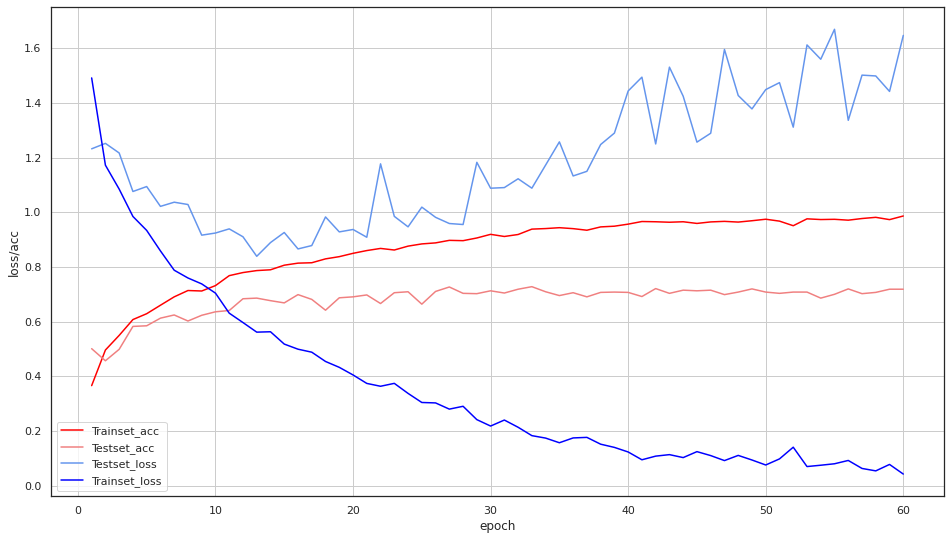

In [ ]:
#sonuçların zaman grafiği - mavi loss - kırmızı acc
sns.set(rc={'figure.figsize':(16, 9)})
sns.set_style("white")

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len+1, acc, c="red", label='Trainset_acc')
plt.plot(x_len+1, val_acc, c="lightcoral", label='Testset_acc')
plt.plot(x_len+1, y_vloss, c="cornflowerblue", label='Testset_loss')
plt.plot(x_len+1, y_loss, c="blue", label='Trainset_loss')

plt.legend(loc='lower left')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()

Olasılık:  0.999998
Tahmin: rose


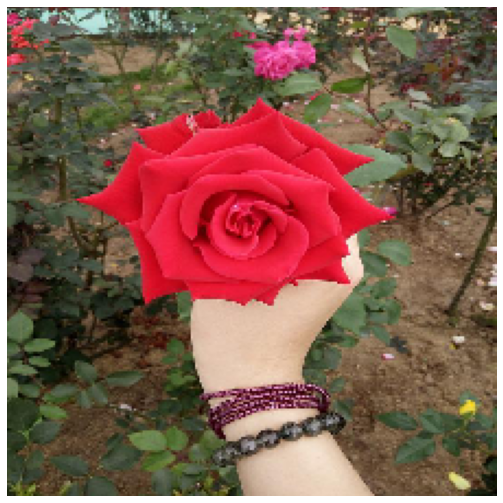

In [ ]:
from keras.preprocessing import image
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

ImagePath='/content/flowerdataset/test/rose/rose.jpg'
img = image.load_img(ImagePath, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0


plt.axis('off')
plt.imshow(img.squeeze())

p= model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Olasılık: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Tahmin:",predicted_class)

Olasılık:  0.9995115
Tahmin: tulip


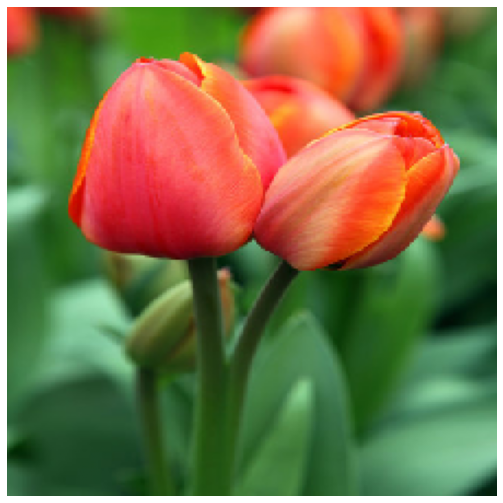

In [ ]:
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

ImagePath='/content/flowerdataset/test/tulip/lale.jpg'
img = image.load_img(ImagePath, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0


plt.axis('off')
plt.imshow(img.squeeze())

p= model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Olasılık: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Tahmin:",predicted_class)

Olasılık:  0.99996424
Tahmin: dandelion


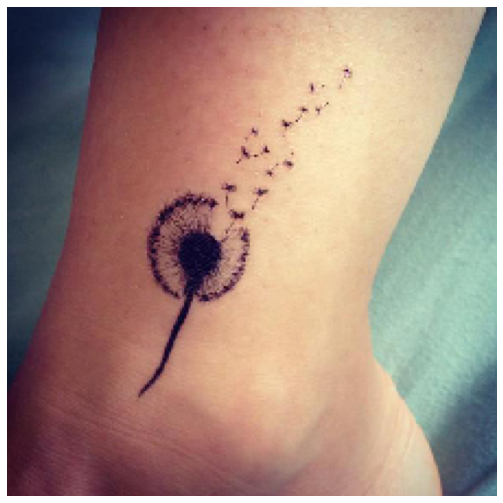

In [ ]:
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

ImagePath='/content/flowerdataset/test/dandelion/karahindiba.jpg'
img = image.load_img(ImagePath, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0


plt.axis('off')
plt.imshow(img.squeeze())

p= model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Olasılık: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Tahmin:",predicted_class)

Olasılık:  1.0
Tahmin: daisy


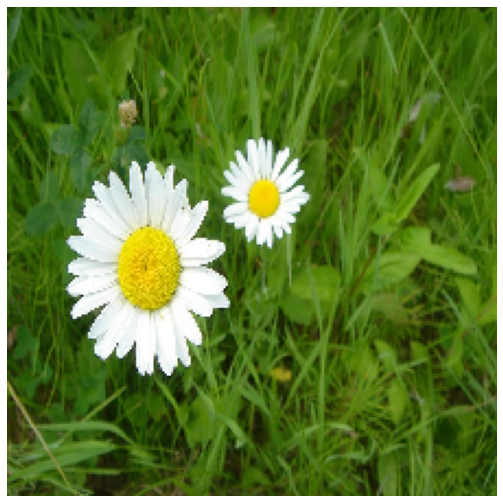

In [ ]:
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

ImagePath='/content/flowerdataset/test/daisy/papatya.jpg'
img = image.load_img(ImagePath, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0


plt.axis('off')
plt.imshow(img.squeeze())

p= model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Olasılık: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Tahmin:",predicted_class)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('Doğrular')

    plt.xlabel('Tahminlenen')

In [ ]:
target_names = []

for key in train_generator.class_indices:

    target_names.append(key)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
Normalized confusion matrix


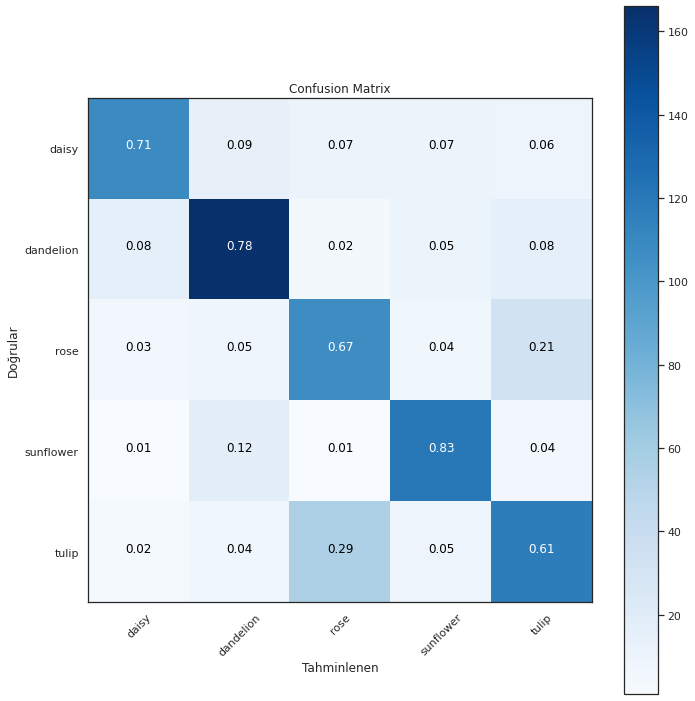

In [ ]:
import itertools    

Y_pred = model.predict_generator(test_generator)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(test_generator.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# VGGNET İLE MODEL OLUŞTURMA

In [ ]:
class VggNet(Sequential):
    def __init__(self, input_shape):
        super().__init__()

        self.add(Conv2D(filters=64, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',
                        input_shape= input_shape))
        self.add(Conv2D(filters=64, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',))
        self.add(MaxPooling2D(pool_size=(2,2)))

        self.add(Conv2D(filters=128, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',))
        self.add(Conv2D(filters=128, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',))
        self.add(MaxPooling2D(pool_size=(2,2)))

        self.add(Conv2D(filters=256, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',))
        self.add(Conv2D(filters=256, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',))
        self.add(Conv2D(filters=256, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',))
        self.add(MaxPooling2D(pool_size=(2,2)))

        self.add(Conv2D(filters=512, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',))
        self.add(Conv2D(filters=512, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',))
        self.add(Conv2D(filters=512, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',))
        self.add(MaxPooling2D(pool_size=(2,2)))

        self.add(Conv2D(filters=512, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',))
        self.add(Conv2D(filters=512, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',))
        self.add(Conv2D(filters=512, kernel_size=(3,3),
                        padding= 'same', activation= 'relu',))
        self.add(MaxPooling2D(pool_size=(2,2)))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(5, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
model2 = VggNet((224, 224, 3))

In [ ]:
model2.summary()

Model: "vgg_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                       

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, fill_mode='nearest',
                                   rotation_range=10 , zoom_range = 0.1)

# test verisinin orijinal kalmasını istiyoruz.
test_datagen = ImageDataGenerator(rescale=1./255)

#Data büyütme ile daha iyi başarı oranı yakalamak istiyoruz. Bu sayede daha fazla verimiz olacak ve overfittingi önlemiş olucaz.

#rescale: normalizasyon işlemi
#horizantal_flip : resmi ters çevirme (yatay)
#width_shift : verilen değerde resmi rastgele oynatma
#fill mode: nearest seçildi fotoğraf değiştiğinde boş kalan pikselleri en yakın piksellerle doldurma

In [ ]:
#generator oluşturma
train_generator = train_datagen.flow_from_directory('/content/flowerdataset/train', target_size=(224, 224), batch_size=64, class_mode='binary')

test_generator = test_datagen.flow_from_directory('/content/flowerdataset/test', target_size=(224, 224), batch_size=64, class_mode='binary', shuffle= False)

Found 3456 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [ ]:
history2 = model2.fit(train_generator, epochs=75, steps_per_epoch=len(train_generator), validation_data= test_generator, validation_steps=len(test_generator), batch_size= 128)

Epoch 1/75
54/54 [==============================] - 121s 2s/step - loss: 1.6016 - accuracy: 0.2321 - val_loss: 1.5722 - val_accuracy: 0.2465
Epoch 2/75
54/54 [==============================] - 97s 2s/step - loss: 1.4558 - accuracy: 0.3290 - val_loss: 1.3444 - val_accuracy: 0.3767
Epoch 3/75
54/54 [==============================] - 97s 2s/step - loss: 1.3034 - accuracy: 0.4094 - val_loss: 1.2959 - val_accuracy: 0.4174
Epoch 4/75
54/54 [==============================] - 97s 2s/step - loss: 1.2072 - accuracy: 0.4818 - val_loss: 1.1474 - val_accuracy: 0.5267
Epoch 5/75
54/54 [==============================] - 97s 2s/step - loss: 1.1418 - accuracy: 0.5142 - val_loss: 1.1993 - val_accuracy: 0.4988
Epoch 6/75
54/54 [==============================] - 97s 2s/step - loss: 1.1007 - accuracy: 0.5312 - val_loss: 1.1911 - val_accuracy: 0.5209
Epoch 7/75
54/54 [==============================] - 97s 2s/step - loss: 1.0802 - accuracy: 0.5333 - val_loss: 1.0782 - val_accuracy: 0.5372
Epoch 8/75
54/54 [=

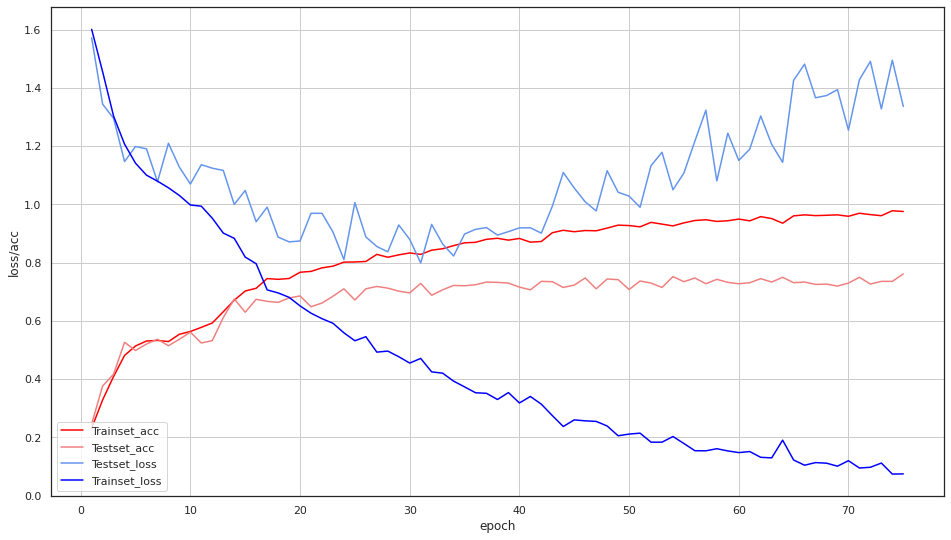

In [ ]:
#sonuçların zaman grafiği - mavi loss - kırmızı acc
sns.set(rc={'figure.figsize':(16, 9)})
sns.set_style("white")

acc= history2.history['accuracy']
val_acc= history2.history['val_accuracy']
y_vloss = history2.history['val_loss']
y_loss = history2.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len+1, acc, c="red", label='Trainset_acc')
plt.plot(x_len+1, val_acc, c="lightcoral", label='Testset_acc')
plt.plot(x_len+1, y_vloss, c="cornflowerblue", label='Testset_loss')
plt.plot(x_len+1, y_loss, c="blue", label='Trainset_loss')

plt.legend(loc='lower left')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()

Olasılık:  0.9999794
Tahmin: rose


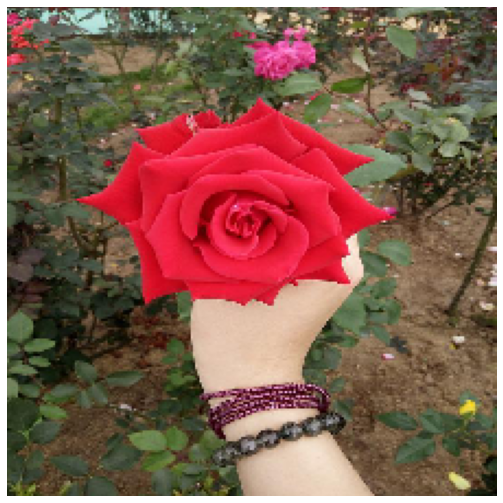

In [ ]:
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

ImagePath='/content/flowerdataset/test/rose/rose.jpg'
img = image.load_img(ImagePath, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0


plt.axis('off')
plt.imshow(img.squeeze())

p= model2.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Olasılık: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Tahmin:",predicted_class)

Olasılık:  1.0
Tahmin: daisy


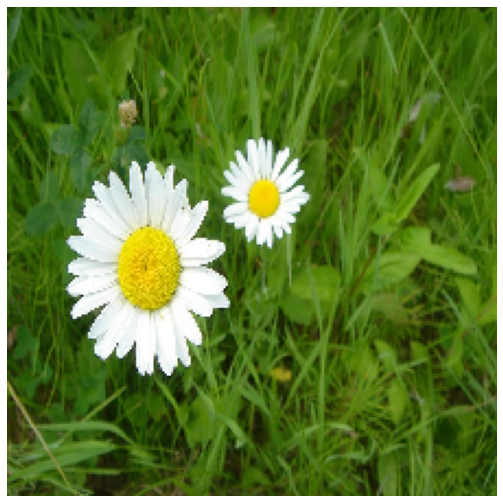

In [ ]:
from keras.preprocessing import image
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

ImagePath='/content/flowerdataset/test/daisy/papatya.jpg'
img = image.load_img(ImagePath, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0


plt.axis('off')
plt.imshow(img.squeeze())

p= model2.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Olasılık: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Tahmin:",predicted_class)

Olasılık:  0.9816435
Tahmin: tulip


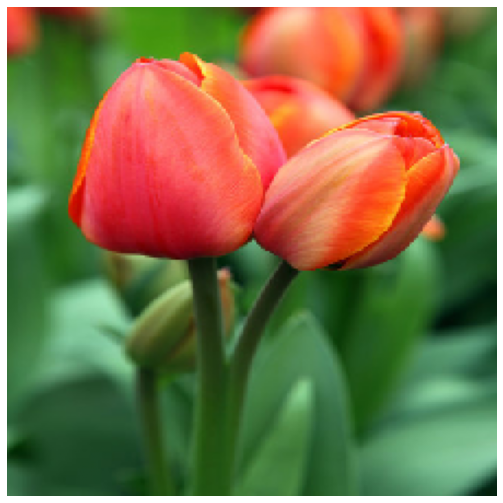

In [ ]:
from keras.preprocessing import image
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

ImagePath='/content/flowerdataset/test/tulip/lale.jpg'
img = image.load_img(ImagePath, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0


plt.axis('off')
plt.imshow(img.squeeze())

p= model2.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Olasılık: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Tahmin:",predicted_class)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('Doğrular')

    plt.xlabel('Tahminlenen')

In [ ]:
target_names = []

for key in train_generator.class_indices:

    target_names.append(key)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
Normalized confusion matrix


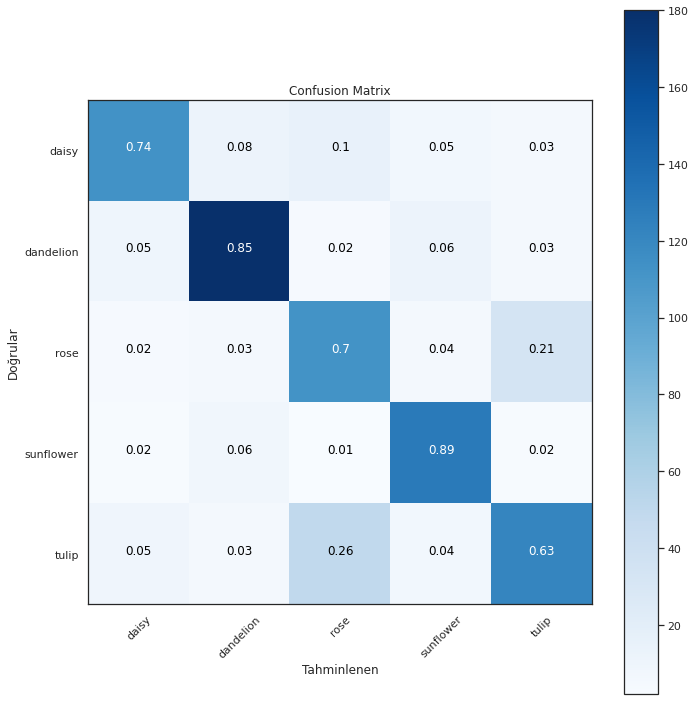

In [ ]:
import itertools    

Y_pred = model2.predict_generator(test_generator)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(test_generator.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# ResNet50 ile Model Oluşturma

In [ ]:
from tensorflow import keras
from keras.applications.resnet import ResNet50
from keras.utils.vis_utils import plot_model
from glob import glob #pythonun belirli bir klasör içindeki dosyaları listelemimze yardımcı olan modül
from keras.models import Model
from keras.layers import Flatten,Dense,Dropout,Softmax,BatchNormalization

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True,  shear_range=0.2 , zoom_range = 0.2)

# test verisinin orijinal kalmasını istiyoruz.
test_datagen = ImageDataGenerator(rescale=1./255)

#Data büyütme ile daha iyi başarı oranı yakalamak istiyoruz. Bu sayede daha fazla verimiz olacak ve overfittingi önlemiş olucaz.

#rescale: normalizasyon işlemi
#horizantal_flip : resmi ters çevirme (yatay)
#width_shift : verilen değerde resmi rastgele oynatma
#fill mode: nearest seçildi fotoğraf değiştiğinde boş kalan pikselleri en yakın piksellerle doldurma

In [ ]:
#generator oluşturma
train_generator = train_datagen.flow_from_directory('/content/flowerdataset/train', target_size=(224, 224), batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory('/content/flowerdataset/test', target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle= False)

Found 3456 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [ ]:
resnet = ResNet50(include_top=False , input_shape=(224, 224, 3) , weights="imagenet")

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
plot_model(resnet)
for layer in resnet.layers:
  layer.trainable = False #Tüm katmanları dondurma.

In [ ]:
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(5,activation="softmax")(x)

In [ ]:
model3 = Model(inputs=resnet.input , outputs=prediction)
plot_model(model3)
model3.compile(optimizer= "adam",
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_generator, epochs=250, steps_per_epoch=len(train_generator), validation_data= test_generator, validation_steps=len(test_generator), batch_size= 128)

Epoch 1/250
108/108 [==============================] - 70s 462ms/step - loss: 3.0424 - accuracy: 0.3365 - val_loss: 2.2423 - val_accuracy: 0.3477
Epoch 2/250
108/108 [==============================] - 48s 448ms/step - loss: 1.7554 - accuracy: 0.4071 - val_loss: 1.6396 - val_accuracy: 0.3977
Epoch 3/250
108/108 [==============================] - 47s 437ms/step - loss: 1.6152 - accuracy: 0.4465 - val_loss: 1.9343 - val_accuracy: 0.4186
Epoch 4/250
108/108 [==============================] - 48s 440ms/step - loss: 1.5586 - accuracy: 0.4748 - val_loss: 1.6957 - val_accuracy: 0.4523
Epoch 5/250
108/108 [==============================] - 47s 437ms/step - loss: 1.3516 - accuracy: 0.5136 - val_loss: 2.7584 - val_accuracy: 0.4919
Epoch 6/250
108/108 [==============================] - 47s 431ms/step - loss: 1.5007 - accuracy: 0.4983 - val_loss: 1.8680 - val_accuracy: 0.4302
Epoch 7/250
108/108 [==============================] - 47s 433ms/step - loss: 1.5724 - accuracy: 0.5064 - val_loss: 1.5673 -